In [182]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [183]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [184]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
experiment = "Lung"
# cores=['DonorA', 'DonorE']
cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4']
datasets = [f'{core}_{i}' for core in cores for i in range(1,5)] + ['F7_3', 'F7_4']
# datasets = ['E6_1', 'E6_2', 'E6_3']

# Load data

In [186]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [187]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [188]:
adatas = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    data_all = df_intensity_TS.iloc[:, 1:].values
    data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    data_all_norm = MinMaxScaler().fit_transform(data_all_norm)
    df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    # sc.pp.normalize_total(adata, target_sum=1)
    # sc.pp.log1p(adata)
    # sc.pp.scale(adata)
    adatas.append(adata)
adata = ad.concat(adatas, join="inner")

Sucessfully read dataset B5_1
Sucessfully read dataset B5_2


C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset B5_3
B5_4 cannot be read
Sucessfully read dataset C6_1


C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset C6_2
Sucessfully read dataset C6_3


C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset C6_4
Sucessfully read dataset D4_1


C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset D4_2
Sucessfully read dataset D4_3
D4_4 cannot be read
Sucessfully read dataset E4_1


C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the fu

Sucessfully read dataset E4_2
Sucessfully read dataset E4_3


C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset E4_4
Sucessfully read dataset E6_1
Sucessfully read dataset E6_2


C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the fu

Sucessfully read dataset E6_3
E6_4 cannot be read
Sucessfully read dataset F4_1


C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset F4_2
Sucessfully read dataset F4_3


C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


F4_4 cannot be read
Sucessfully read dataset F7_3
Sucessfully read dataset F7_4


C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_29164/2826454643.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [189]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 40000)].index.tolist()

In [190]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}_R2.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


In [191]:
sc.pp.normalize_total(adata, target_sum=1e5)
sc.pp.log1p(adata)
sc.pp.scale(adata)

normalizing counts per cell
    finished (0:00:00)


In [192]:
adata = adata[~adata.obs.Dataset.isin(['F7_1', 'F7_2'])]
adata_IMC_cluster = adata_IMC_cluster[~adata_IMC_cluster.obs.Dataset.isin(['F7_1', 'F7_2'])]

## Get literature lut

In [193]:
SIMS_masses = adata.var_names

In [194]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_05052022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()

# get matched table by looking at difference with error
error = 0.5
matched_dfs = []
for mz in SIMS_masses.astype(float):
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
        
matched = pd.concat(matched_dfs)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [195]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)

SIMS_nm_subset = SIMS_masses_subset + 'm/z ' + SIMS_name_subset

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 43


In [196]:
adata_all = adata.copy()
adata = adata[:, SIMS_masses_subset]
adata.var_names = SIMS_nm_subset

# Rename clusters

In [197]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [198]:
type_dict = {'0': 'ECad+Pank',
            '1': 'Other',
            '2': 'CD3+CD4+', 
            '3': 'CD68+CD4+',
            '4': 'COL+SMA',
            '5': 'ECad+Pank',
            '6': 'CD31+',
            '7': 'GranzymeB+',
            }

In [199]:
adata_CN = adata_IMC_cluster.copy()

In [200]:
adata_CN.obs['Type'] = (
    adata_CN.obs['leiden']
    .map(type_dict)
    .astype("category")
)
adata_CN.uns['Type_colors'] = adata_CN.uns['leiden_colors'][:len(np.unique(adata_CN.obs['Type']))]

In [201]:
adata.obs["Type"] = adata_CN.obs["Type"]
adata.uns["Type_colors"] = adata_CN.uns["Type_colors"]
adata.obsm["spatial"] = adata_CN.obsm["spatial"]

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Type']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


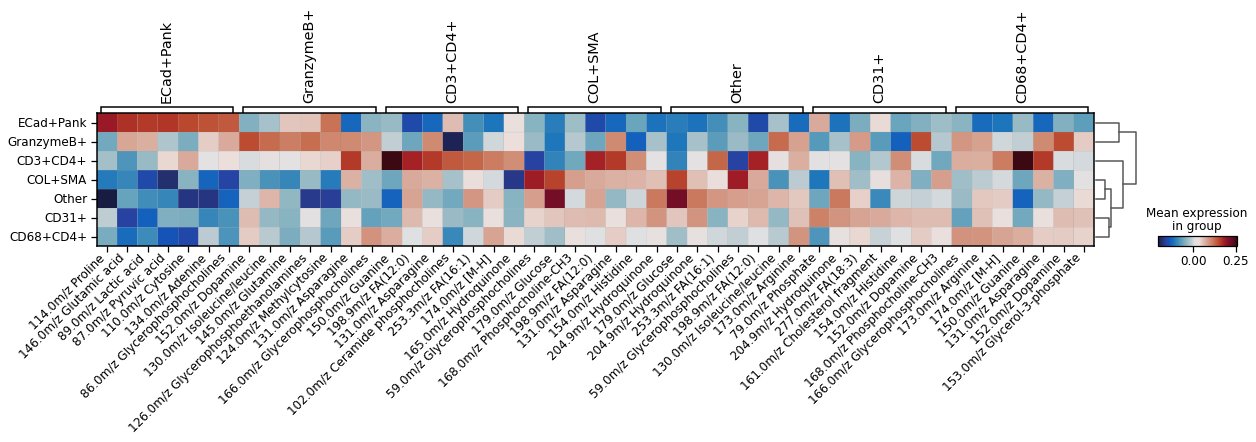

In [202]:
sc.tl.dendrogram(adata, groupby='Type')
sc.tl.rank_genes_groups(adata, groupby='Type', method='t-test_overestim_var')

with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.rank_genes_groups_matrixplot(adata, n_genes=7, use_raw=False, cmap=heatmap_cmp, show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 45, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

In [212]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata, group=None)

# Get top diff expression
topk=1
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
masses = np.unique(np.concatenate([masses_largest, masses_lowest]))

In [213]:
# Extract dataframe
var = 'Type'

adata_subset = adata[:,masses]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()

df_SIMS_grouped = df_SIMS.groupby([var]).mean()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Type']`


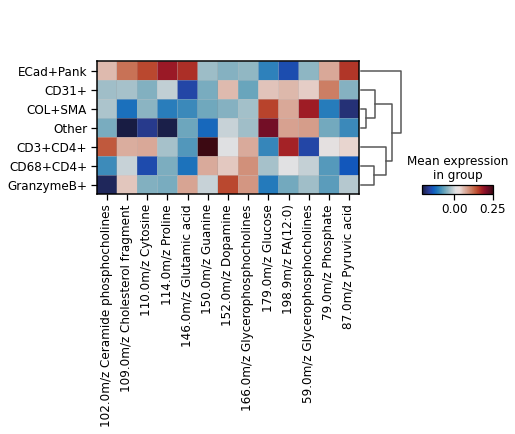

In [214]:
adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs['Type'] = df_SIMS_grouped.index.tolist()
adata_grouped.obs['Type'] = adata_grouped.obs['Type'].astype('category')

sc.tl.dendrogram(adata_grouped, groupby='Type')
with sns.plotting_context('notebook', font_scale=1.2):
    sc.pl.matrixplot(adata_grouped, 
                     var_names=adata_grouped.var_names, 
                     groupby='Type',
                     cmap=heatmap_cmp,
                     dendrogram=True,
                    )

In [270]:
# Get subset of masses
adata_subset = adata[:,masses]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
# df_SIMS.drop(['1.0'], axis=1, inplace=True)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))
df_SIMS_var['Normalized ion count'] = df_SIMS_var['Normalized ion count']+0.3

df = df_SIMS_var[df_SIMS_var[var] == 'Tumor'].groupby('mz').mean()
df.sort_values('Normalized ion count', inplace=True)
masses_sorted = df.index.tolist()

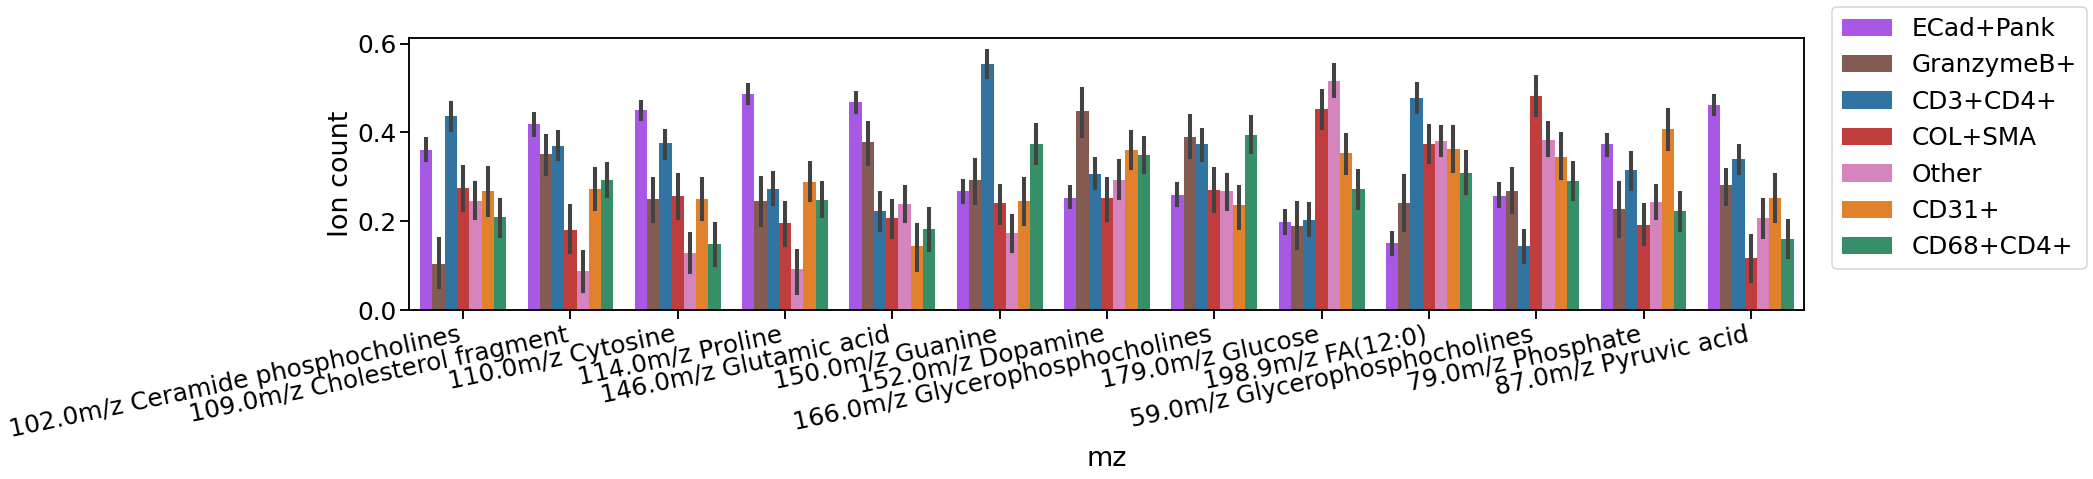

In [273]:
sns.set_context('talk', font_scale=1.5)

var = 'Type'
hue_order = adata_subset.uns[f'dendrogram_{var}']['categories_ordered']
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(25,5))
ax = sns.barplot(data=df_SIMS_var, 
            hue=var, 
            x='mz', 
            y='Normalized ion count',
            hue_order = hue_order,
            ax=ax, 
            palette=palette
            )

plt.xticks(rotation = 12, ha='right')
plt.ylabel('Ion count')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)




# Manual gating

In [283]:
type_dict = { '0': 'Other',
            '1': 'COL+SMA',
            '2': 'ECad+Pank',
            '3': 'CD3+CD4+', 
            '4': 'CD68+',
            '5': 'CD31+',
            '6': 'GranzymeB+',
            '7': 'CD8+'
            }

In [284]:
df = pd.DataFrame(adata_CN.X, columns=adata_CN.var_names)

In [285]:
df.columns

Index(['CD20', 'CD3', 'CD31', 'CD4', 'CD68', 'CD8', 'COL1', 'ECadherin',
       'GranzymeB', 'PanKeratin', 'SMA', 'Vimentin'],
      dtype='object')

In [288]:
# Manual gating

df['Type'] = '0'
df.loc[(df[["PanKeratin", "ECadherin"]]>0.25).any(1), 'Type'] = '2'
df.loc[(df[["SMA", "COL1"]]>0.25).any(1), 'Type'] = '1'
df.loc[(df[["CD4", 'CD3']]>0.25).all(1), 'Type'] = '3'
df.loc[(df[["CD68"]]>0.25).all(1), 'Type'] = '4'
df.loc[(df[["CD31"]]>0.25).all(1), 'Type'] = '5'
df.loc[(df[["GranzymeB"]]>0.25).all(1), 'Type'] = '6'
df.loc[(df[["CD8"]]>0.25).all(1), 'Type'] = '7'


In [292]:
adata.obs['Type'] = df.Type.tolist()

adata_CN.obs['Type'] = (
    adata_CN.obs['leiden']
    .map(type_dict)
    .astype("category")
)
adata_CN.uns['Type_colors'] = adata_CN.uns['leiden_colors'][:len(np.unique(adata_CN.obs['Type']))]

In [293]:
adata.obs["Type"] = adata_CN.obs["Type"]
adata.uns["Type_colors"] = adata_CN.uns["Type_colors"]
adata.obsm["spatial"] = adata_CN.obsm["spatial"]

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Type']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


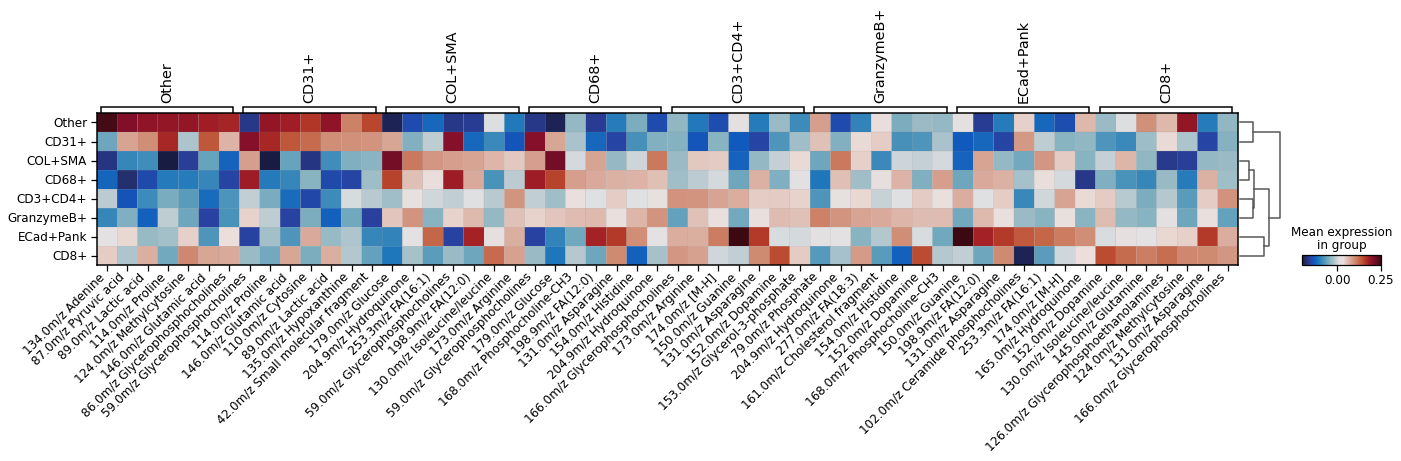

In [294]:
sc.tl.dendrogram(adata, groupby='Type')
sc.tl.rank_genes_groups(adata, groupby='Type', method='t-test_overestim_var')

with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.rank_genes_groups_matrixplot(adata, n_genes=7, use_raw=False, cmap=heatmap_cmp, show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 45, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

In [295]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata, group=None)

# Get top diff expression
topk=1
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
masses = np.unique(np.concatenate([masses_largest, masses_lowest]))

In [296]:
# Extract dataframe
var = 'Type'

adata_subset = adata[:,masses]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()

df_SIMS_grouped = df_SIMS.groupby([var]).mean()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Type']`


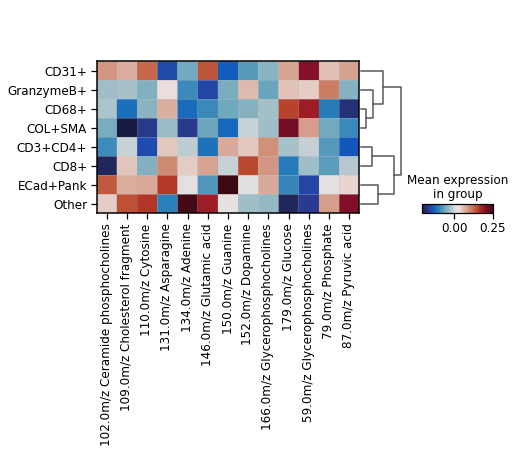

In [297]:
adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs['Type'] = df_SIMS_grouped.index.tolist()
adata_grouped.obs['Type'] = adata_grouped.obs['Type'].astype('category')

sc.tl.dendrogram(adata_grouped, groupby='Type')
with sns.plotting_context('notebook', font_scale=1.2):
    sc.pl.matrixplot(adata_grouped, 
                     var_names=adata_grouped.var_names, 
                     groupby='Type',
                     cmap=heatmap_cmp,
                     dendrogram=True,
                    )

In [303]:
# Get subset of masses
adata_subset = adata[:,masses]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
# df_SIMS.drop(['1.0'], axis=1, inplace=True)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))
df_SIMS_var['Normalized ion count'] = df_SIMS_var['Normalized ion count']+0.3
df_SIMS_var = df_SIMS_var[df_SIMS_var['Type'] != 'Other']

df = df_SIMS_var[df_SIMS_var[var] == 'Tumor'].groupby('mz').mean()
df.sort_values('Normalized ion count', inplace=True)
masses_sorted = df.index.tolist()

In [305]:
df_SIMS_var.Type.unique()

array(['ECad+Pank', 'GranzymeB+', 'CD3+CD4+', 'COL+SMA', 'CD68+', 'CD31+',
       'CD8+'], dtype=object)

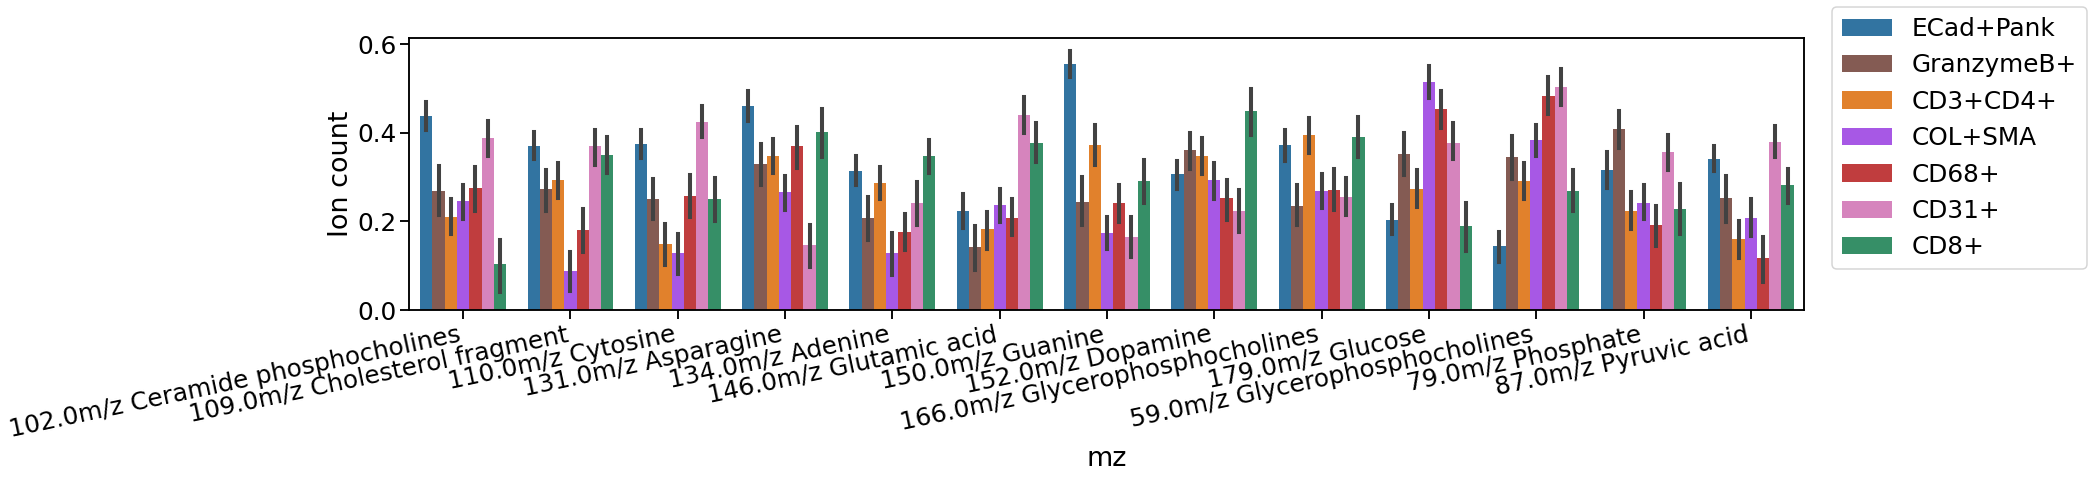

In [306]:
sns.set_context('talk', font_scale=1.5)

var = 'Type'
# hue_order = adata_subset.uns[f'dendrogram_{var}']['categories_ordered']
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(25,5))
ax = sns.barplot(data=df_SIMS_var, 
            hue=var, 
            x='mz', 
            y='Normalized ion count',
            # hue_order = hue_order,
            ax=ax, 
            palette=palette
            )

plt.xticks(rotation = 12, ha='right')
plt.ylabel('Ion count')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)


